# Khai báo thư viện

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import tensorflow as tf

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Bước 1: Đọc dữ liệu từ file excel/csv

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Hoc_Tap/CS116_LapTrinhPython/churn_modelling/Churn_Modelling.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [111]:
label = data.Exited.to_numpy()
unique, counts = np.unique(label, return_counts=True)
dict(zip(unique, counts))

{0: 7963, 1: 2037}

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# Bước 2: Chuẩn hóa các cột dữ liệu thuộc dạng không có tình thứ tự (dữ liệu rời rạc) thành dạng One Hot Encoding

In [22]:
le = LabelEncoder()
enc = OneHotEncoder(handle_unknown='ignore')

In [21]:
object_data = data[['Geography', 'Gender']]
object_data

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female
...,...,...
9995,France,Male
9996,France,Male
9997,France,Female
9998,Germany,Male


In [27]:
X = object_data.apply(le.fit_transform)
X

,Geography,Gender
0,0,0
1,2,0
2,0,0
3,0,0
4,2,0
...,...,...
9995,0,1
9996,0,1
9997,0,0
9998,1,1


In [31]:
label = enc.fit(X).transform(X).toarray()
label

array([[1., 0., 0., 1., 0.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.]])

In [33]:
onehot_df = pd.DataFrame(label, columns=['France', 'Germany', 'Spain', 'Female', 'Male'])
onehot_df

,France,Germany,Spain,Female,Male
0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,1.0
9996,1.0,0.0,0.0,0.0,1.0
9997,1.0,0.0,0.0,1.0,0.0
9998,0.0,1.0,0.0,0.0,1.0


In [35]:
final_df = pd.concat([data, onehot_df], axis=1, join='inner')
final_df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,1.0,0.0,0.0,0.0,1.0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,1.0,0.0,0.0,0.0,1.0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1.0,0.0,0.0,1.0,0.0
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,0.0,1.0,0.0,0.0,1.0


In [41]:
X = final_df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Geography', 'Gender', 'Exited']).to_numpy()
y = final_df.Exited.to_numpy()

# Bước 3: Chia dữ liệu ra làm 2 tập train và test 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bước 4: Chuẩn hóa dữ liệu train bằng standard scaler

In [48]:
scaler = StandardScaler()

In [50]:
X_train = scaler.fit_transform(X_train)

# Bước 5: Xây dựng mô hình Mạng Neural Network bằng thư viện Keras và lớp đối tượng Dense

In [67]:
net = tf.keras.models.Sequential()
net.add(tf.keras.layers.Dense(6, activation='relu'))
net.add(tf.keras.layers.Dense(6, activation='relu'))
net.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [68]:
net.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=["accuracy"])

# Bước 6: Huấn luyện mạng với thuật toán Adam sử dụng hàm độ lỗi Binary Cross Entropy

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [59]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [69]:
history_net = net.fit(X_train, y_train, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/1000
175/175 [==============================] - 1s 4ms/step - loss: 0.5312 - accuracy: 0.7962 - val_loss: 0.4970 - val_accuracy: 0.7900
Epoch 2/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.4915 - accuracy: 0.7964 - val_loss: 0.4750 - val_accuracy: 0.7900
Epoch 3/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.7964 - val_loss: 0.4599 - val_accuracy: 0.7900
Epoch 4/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.4579 - accuracy: 0.7964 - val_loss: 0.4475 - val_accuracy: 0.7900
Epoch 5/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.7970 - val_loss: 0.4380 - val_accuracy: 0.7900
Epoch 6/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.4369 - accuracy: 0.8021 - val_loss: 0.4325 - val_accuracy: 0.7996
Epoch 7/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.8095 - val_loss: 0.4300 - val_accuracy:

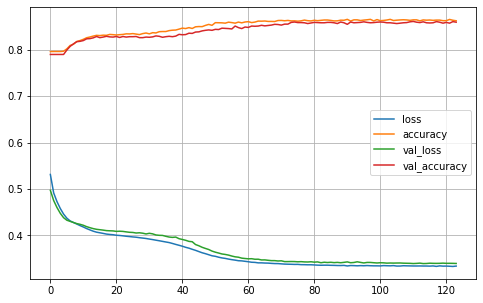

In [71]:
pd.DataFrame(history_net.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Bước 7: Test và đánh giá kết quả

In [79]:
def draw_cf_matrix(label, pred):
  cf_matrix = confusion_matrix(label, pred)
  ax = plt.subplot()
  sns.heatmap(cf_matrix, annot=True, ax = ax, fmt='g', cmap='Greens')
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels([0, 1])
  ax.yaxis.set_ticklabels([0, 1])
  cf_matrix

In [72]:
X_test = scaler.fit_transform(X_test)

In [76]:
y_predict = net.predict(X_test)
y_predict

array([[0.07285514],
       [0.02902305],
       [0.11009726],
       ...,
       [0.7738104 ],
       [0.09193644],
       [0.39001954]], dtype=float32)

In [100]:
threshold = 0.5
y_predict = np.where(y_predict < threshold, 0, 1)
y_predict

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1607
           1       0.73      0.49      0.59       393

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000



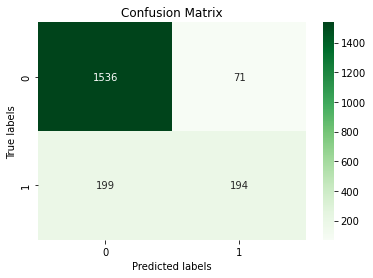

In [101]:
draw_cf_matrix(y_test.reshape(-1,1), y_predict)
print(classification_report(y_test.reshape(-1,1), y_predict))

# Bước 8: Đánh giá độ chính xác bằng phương pháp KFold Cross Validation

In [103]:
kf = KFold(n_splits=5, shuffle=True)

In [108]:
accuracy_list = []
threshold = 0.5
y_test_lst = []
y_predict_lst = []
for train_index, test_index in kf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_lst.append(y_test.reshape(-1,1))

  X_train = scaler.fit_transform(X_train)

  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
  history_net = net.fit(X_train, y_train, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

  X_test = scaler.fit_transform(X_test)
  y_predict = net.predict(X_test)

  y_predict = np.where(y_predict < threshold, 0, 1)
  y_predict_lst.append(y_predict)

  accuracy_list.append(round(accuracy_score(y_test.reshape(-1,1),y_predict), 2))

print(f'Mean Accuracy: {round(np.mean(accuracy_list), 2)}')

Epoch 1/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.3356 - accuracy: 0.8629 - val_loss: 0.3346 - val_accuracy: 0.8696
Epoch 2/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.3348 - accuracy: 0.8609 - val_loss: 0.3361 - val_accuracy: 0.8633
Epoch 3/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.3346 - accuracy: 0.8620 - val_loss: 0.3353 - val_accuracy: 0.8683
Epoch 4/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.3341 - accuracy: 0.8611 - val_loss: 0.3366 - val_accuracy: 0.8679
Epoch 5/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.3340 - accuracy: 0.8602 - val_loss: 0.3368 - val_accuracy: 0.8683
Epoch 6/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.3337 - accuracy: 0.8627 - val_loss: 0.3367 - val_accuracy: 0.8683
Epoch 7/1000
175/175 [==============================] - 0s 2ms/step - loss: 0.3334 - accuracy: 0.8627 - val_loss: 0.3386 - val_accuracy: